### Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import collections
from sklearn.model_selection import train_test_split
#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
#from keras.utils import to_categorical
#from keras.preprocessing import image

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

import PIL
from copy import deepcopy

In [ ]:
#!unzip /content/tartu-object-detection-part-2.zip

### Loading in data, train and test sets

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
labels_data = pd.read_csv("data/labels.csv")

In [4]:
train

image_id                 labels
0    img256.jpg    l16 l18 l23 l25 l73
1     img98.jpg         l0 l24 l26 l39
2    img147.jpg                 l14 l3
3    img254.jpg             l2 l25 l29
4    img160.jpg      l0 l32 l38 l40 l6
..          ...                    ...
200  img105.jpg                    l51
201  img198.jpg      l0 l10 l11 l65 l7
202   img82.jpg                     l2
203  img124.jpg   l0 l1 l19 l22 l34 l6
204   img23.jpg  l1 l15 l18 l2 l21 l71

[205 rows x 2 columns]

### Turning labels column to multiple label columns
Kinda like onehotencoder

In [5]:
for label in labels_data.label_id:
  column_values = []
  for index, entry in train.iterrows():
    if label in entry.labels.split(" "):
      column_values.append(1)
    else:
      column_values.append(0)
  train[label] = column_values

In [6]:
train[:5]

image_id               labels  l0  l1  l2  l3  l4  l5  l6  l7  ...  l82  \
0  img256.jpg  l16 l18 l23 l25 l73   0   0   0   0   0   0   0   0  ...    0   
1   img98.jpg       l0 l24 l26 l39   1   0   0   0   0   0   0   0  ...    0   
2  img147.jpg               l14 l3   0   0   0   1   0   0   0   0  ...    0   
3  img254.jpg           l2 l25 l29   0   0   1   0   0   0   0   0  ...    0   
4  img160.jpg    l0 l32 l38 l40 l6   1   0   0   0   0   0   1   0  ...    0   

   l83  l84  l85  l86  l87  l88  l89  l90  l91  
0    0    0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0    0    0  
3    0    0    0    0    0    0    0    0    0  
4    0    0    0    0    0    0    0    0    0  

[5 rows x 94 columns]

In [7]:
print(train[:1].l16)
print(train[:1].l18)
print(train[:1].l23)
print(train[:1].l25)
print(train[:1].l73)

0    1
Name: l16, dtype: int64
0    1
Name: l18, dtype: int64
0    1
Name: l23, dtype: int64
0    1
Name: l25, dtype: int64
0    1
Name: l73, dtype: int64


### Reading in pictures

uint8
(450, 600, 3)


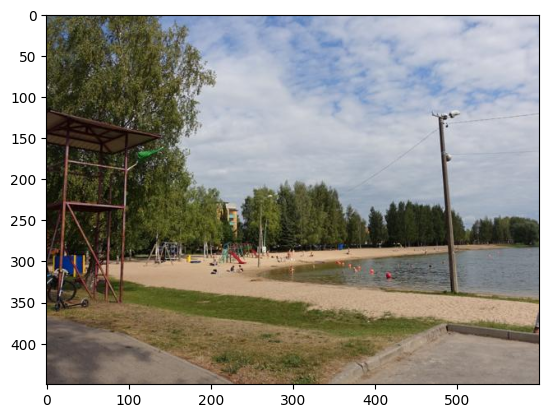

In [9]:
pic = image.imread("data/images/images/img120.jpg")
print(pic.dtype)
print(pic.shape)
plt.imshow(pic)
plt.show()

In [10]:
imageDir = "data/images/images/"
images = dict()
for imageName in os.listdir(imageDir):
  pic = image.imread(f"{imageDir}{imageName}")
  images[imageName] = pic

In [11]:
print(f"CSV files have {len(train) + len(test)} entries, but we have {len(images)} images.")

CSV files have 293 entries, but we have 294 images.


Going through train and test CSV and leaving only image entries that we have picture for.

In [12]:
train = train[train["image_id"].isin(images.keys())]
train = train.reset_index(drop=True)
test = test[test["image_id"].isin(images.keys())]
test = test.reset_index(drop=True)
print(len(train))
print(len(test))

201
86


In [13]:
train

image_id                 labels  l0  l1  l2  l3  l4  l5  l6  l7  ...  \
0    img256.jpg    l16 l18 l23 l25 l73   0   0   0   0   0   0   0   0  ...   
1     img98.jpg         l0 l24 l26 l39   1   0   0   0   0   0   0   0  ...   
2    img147.jpg                 l14 l3   0   0   0   1   0   0   0   0  ...   
3    img254.jpg             l2 l25 l29   0   0   1   0   0   0   0   0  ...   
4    img160.jpg      l0 l32 l38 l40 l6   1   0   0   0   0   0   1   0  ...   
..          ...                    ...  ..  ..  ..  ..  ..  ..  ..  ..  ...   
196  img105.jpg                    l51   0   0   0   0   0   0   0   0  ...   
197  img198.jpg      l0 l10 l11 l65 l7   1   0   0   0   0   0   0   1  ...   
198   img82.jpg                     l2   0   0   1   0   0   0   0   0  ...   
199  img124.jpg   l0 l1 l19 l22 l34 l6   1   1   0   0   0   0   1   0  ...   
200   img23.jpg  l1 l15 l18 l2 l21 l71   0   1   1   0   0   0   0   0  ...   

     l82  l83  l84  l85  l86  l87  l88  l89  l90  l91  
0      0    0    0    0    0    0    0    0    0    0  
1      0    0    0    0    0    0    0    0    0    0  
2      0    0    0    0    0    0    0    0    0    0  
3      0    0    0    0    0    0    0    0    0    0  
4      0    0    0    0    0    0    0    0    0    0  
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
196    0    0    0    0    0    0    0    0    0    0  
197    0    0    0    0    0    0    0    0    0    0  
198    0    0    0    0    0    0    0    0    0    0  
199    0    0    0    0    0    0    0    0    0    0  
200    0    0    0    0    0    0    0    0    0    0  

[201 rows x 94 columns]

Adding imagedata to dataframe

In [14]:
train_images = []
test_images = []
for index, entry in train.iterrows():
  train_images.append(images[entry.image_id])
for index, entry in test.iterrows():
  test_images.append(images[entry.image_id])
train["image_data"] = train_images
test["image_data"] = test_images

In [15]:
train[:5]

image_id               labels  l0  l1  l2  l3  l4  l5  l6  l7  ...  l83  \
0  img256.jpg  l16 l18 l23 l25 l73   0   0   0   0   0   0   0   0  ...    0   
1   img98.jpg       l0 l24 l26 l39   1   0   0   0   0   0   0   0  ...    0   
2  img147.jpg               l14 l3   0   0   0   1   0   0   0   0  ...    0   
3  img254.jpg           l2 l25 l29   0   0   1   0   0   0   0   0  ...    0   
4  img160.jpg    l0 l32 l38 l40 l6   1   0   0   0   0   0   1   0  ...    0   

   l84  l85  l86  l87  l88  l89  l90  l91  \
0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0    0    0   

                                          image_data  
0  [[[135, 159, 187], [135, 159, 187], [134, 158,...  
1  [[[176, 192, 205], [176, 192, 205], [177, 193,...  
2  [[[89, 73, 73], [98, 84, 83], [99, 88, 86], [1...  
3  [[[159, 181, 202], [158, 180, 201], [158, 180,...  
4  [[[149, 180, 162], [152, 185, 168], [153, 187,...  

[5 rows x 95 columns]

In [16]:
train_X = train.image_data
train_y = train.drop(["image_id", "labels", "image_data"], axis = 1)
test_X = test.image_data

In [17]:
train_X[0]

array([[[135, 159, 187],
        [135, 159, 187],
        [134, 158, 186],
        ...,
        [216, 224, 237],
        [217, 224, 240],
        [215, 224, 239]],

       [[136, 160, 188],
        [135, 159, 187],
        [134, 158, 186],
        ...,
        [216, 224, 237],
        [217, 224, 240],
        [215, 224, 239]],

       [[136, 160, 188],
        [135, 159, 187],
        [134, 158, 186],
        ...,
        [216, 224, 237],
        [216, 223, 239],
        [215, 224, 239]],

       ...,

       [[ 57,  58,  63],
        [ 69,  70,  75],
        [ 71,  72,  77],
        ...,
        [115, 116, 120],
        [110, 111, 115],
        [110, 111, 115]],

       [[ 54,  54,  62],
        [ 60,  60,  68],
        [ 59,  59,  67],
        ...,
        [114, 115, 119],
        [121, 122, 126],
        [122, 123, 127]],

       [[ 61,  61,  71],
        [ 59,  59,  69],
        [ 62,  62,  70],
        ...,
        [113, 114, 118],
        [111, 112, 116],
        [113, 114, 118]]

In [18]:
train.labels

0        l16 l18 l23 l25 l73
1             l0 l24 l26 l39
2                     l14 l3
3                 l2 l25 l29
4          l0 l32 l38 l40 l6
               ...          
196                      l51
197        l0 l10 l11 l65 l7
198                       l2
199     l0 l1 l19 l22 l34 l6
200    l1 l15 l18 l2 l21 l71
Name: labels, Length: 201, dtype: object

In [19]:
train_y

l0  l1  l2  l3  l4  l5  l6  l7  l8  l9  ...  l82  l83  l84  l85  l86  \
0     0   0   0   0   0   0   0   0   0   0  ...    0    0    0    0    0   
1     1   0   0   0   0   0   0   0   0   0  ...    0    0    0    0    0   
2     0   0   0   1   0   0   0   0   0   0  ...    0    0    0    0    0   
3     0   0   1   0   0   0   0   0   0   0  ...    0    0    0    0    0   
4     1   0   0   0   0   0   1   0   0   0  ...    0    0    0    0    0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...   
196   0   0   0   0   0   0   0   0   0   0  ...    0    0    0    0    0   
197   1   0   0   0   0   0   0   1   0   0  ...    0    0    0    0    0   
198   0   0   1   0   0   0   0   0   0   0  ...    0    0    0    0    0   
199   1   1   0   0   0   0   1   0   0   0  ...    0    0    0    0    0   
200   0   1   1   0   0   0   0   0   0   0  ...    0    0    0    0    0   

     l87  l88  l89  l90  l91  
0      0    0    0    0    0  
1      0    0    0    0    0  
2      0    0    0    0    0  
3      0    0    0    0    0  
4      0    0    0    0    0  
..   ...  ...  ...  ...  ...  
196    0    0    0    0    0  
197    0    0    0    0    0  
198    0    0    0    0    0  
199    0    0    0    0    0  
200    0    0    0    0    0  

[201 rows x 92 columns]

Just checking

img198 l0 l10 l11 l65 l7

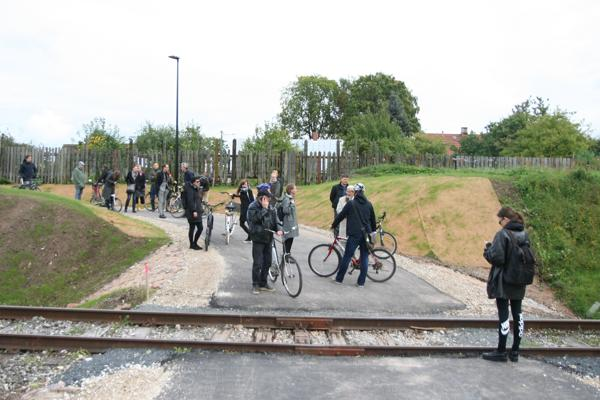

In [20]:
img198labels = train_y.iloc[[197]]
img198labels.columns[img198labels.iloc[0]==1]

Index(['l0', 'l7', 'l10', 'l11', 'l65'], dtype='object')

<class 'numpy.ndarray'>


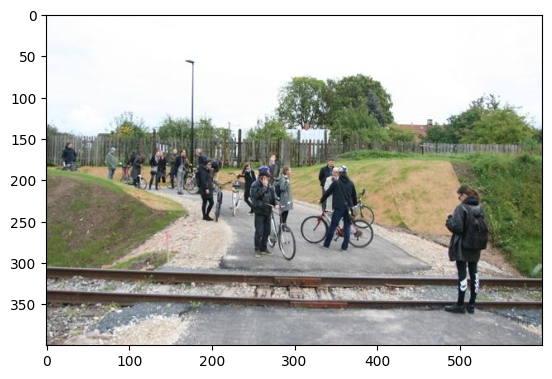

In [21]:
print(type(train_X.iloc[[197][0]]))
plt.imshow(train_X.iloc[[197][0]])
plt.show()

In [22]:
print(f"Loaded in {len(train_X), len(train_y)} train images and {len(test_X)} test images.")
print(f"Total: {len(train_X) + len(test_X)}")

Loaded in (201, 201) train images and 86 test images.
Total: 287


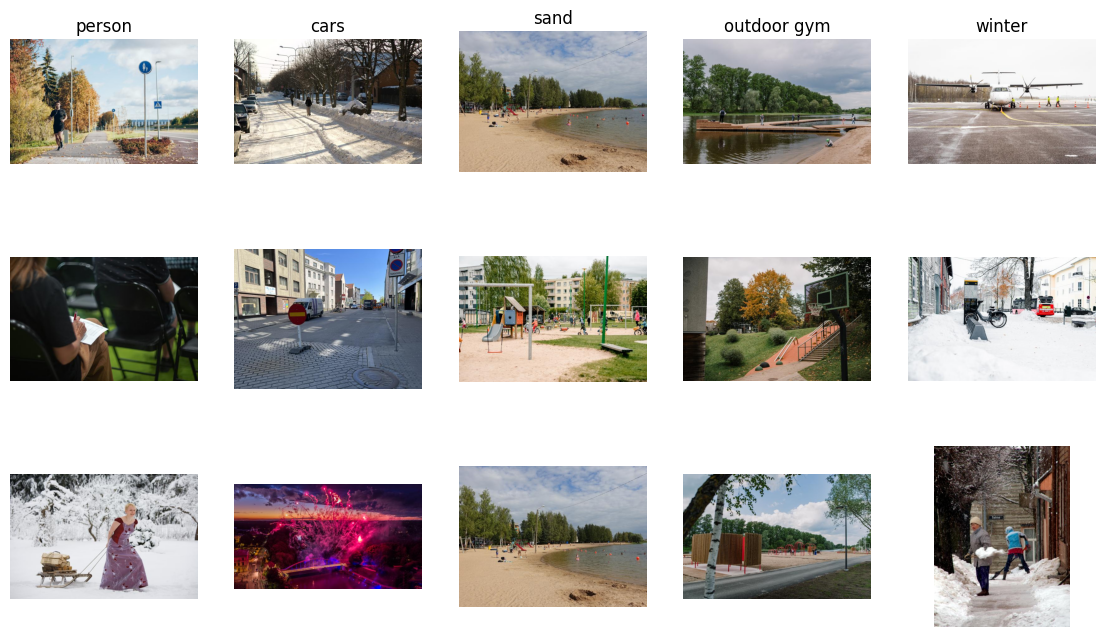

In [23]:
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
# "Names" of classes:
class_names = ['l8','l9','l22','l74','l17']
readable_names = {"l8":"person", "l9":"cars", "l22":"sand", "l74":"outdoor gym", "l17":"winter"}
num_classes = len(class_names)

samples_per_class = 3 # Number of images from each class we want to see
for y, cls in enumerate(class_names):
    idxs = np.flatnonzero(train_y[cls])
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_X[idx], plt.get_cmap('gray'))
        plt.axis('off')
        if i == 0:
            plt.title(readable_names[cls])
plt.show()

### How to process images?

Images have different sizes

In [ ]:
min_width = 5000
max_width = 0
min_height = 5000
max_height = 0
widths = []
heights = []
for i in range(len(train_X)):
  h, w, c = train_X[i].shape
  widths.append(w)
  heights.append(h)
  #print(h, w, c)
  if h > max_height:
    max_height = h
  elif h < min_height:
    min_height = h
  elif w > max_width:
    max_width = w
  elif w < min_width:
    min_width = w
print("min w-h", min_width, min_height)
print("max w-h", max_width, max_height)
print(f"Avg w {sum(widths) / len(widths)} and h {sum(heights) / len(heights)}.")

min w-h 400 284
max w-h 600 600
Avg w 572.5522388059702 and h 432.7860696517413.


In [ ]:
a = np.array([[2,3],[4,4], [2,3]])
a.shape
train_X[0].shape

(600, 450, 3)

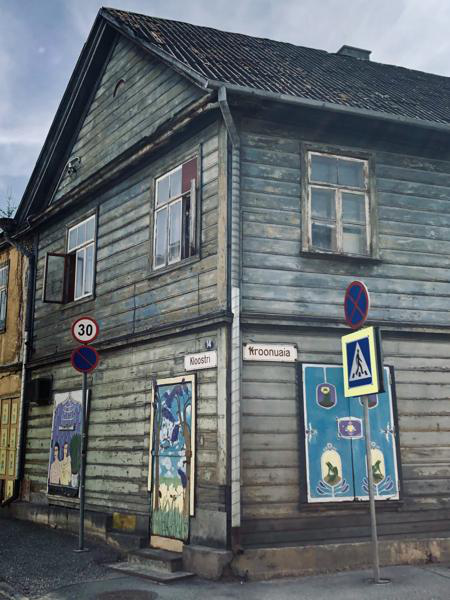

In [ ]:
ims = PIL.Image.fromarray(train_X[0])
ims

225 300


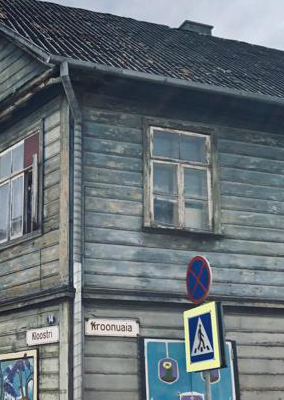

In [ ]:
a = deepcopy(train_X[0])
h_centre = int(train_X[0].shape[0] / 2)
w_centre = int(train_X[0].shape[1] / 2)
print(w_centre, h_centre)
ab = a[w_centre-200:w_centre + 200, h_centre - 142:h_centre + 142]
im = PIL.Image.fromarray(ab)
im

Cropping all images to the smallest image size loses a lot of information.

Resizing to avg.

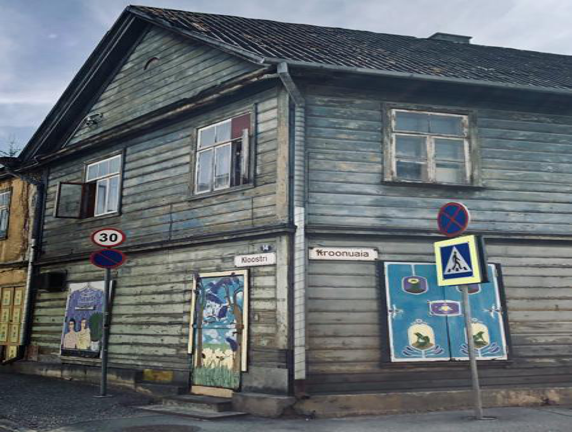

In [ ]:
im = PIL.Image.fromarray(train_X[0])
img_resized = im.resize((572, 432))
img_resized

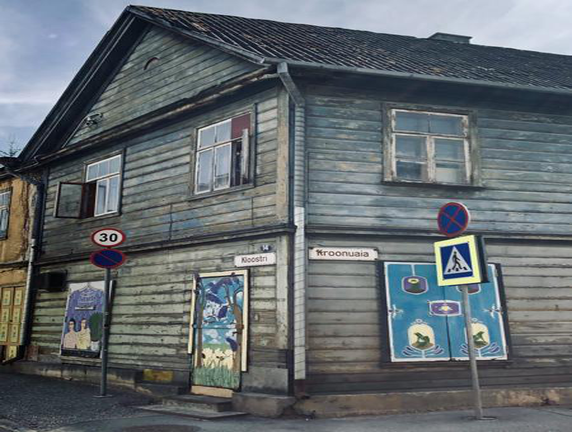

In [ ]:
im = PIL.Image.fromarray(train_X[0])
img_resized = im.resize((572, 432), PIL.Image.LANCZOS)
img_resized

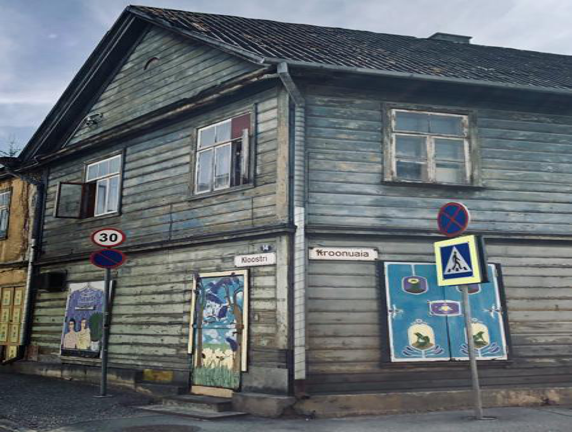

In [ ]:
im = PIL.Image.fromarray(train_X[0])
img_resized = im.resize((572, 432), PIL.Image.BICUBIC)
img_resized

In [ ]:
train_X_resized = []
for i in range(len(train_X)):
  im = PIL.Image.fromarray(train_X[i])
  img_resized = im.resize((572, 432), PIL.Image.BICUBIC)
  # to grayscale
  #img_grayscaled = img_resized.convert("L")
  train_X_resized.append(np.array(img_resized))

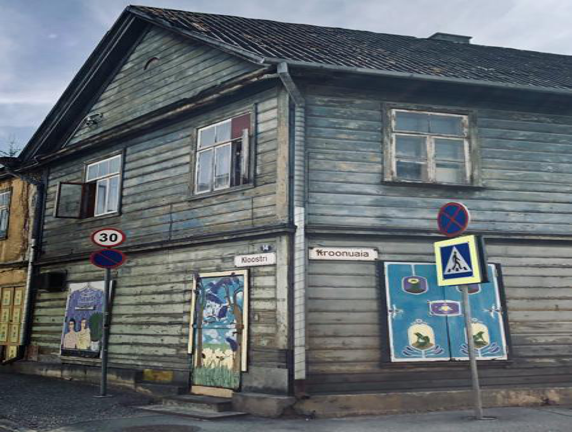

In [ ]:
train_X_resized = np.array(train_X_resized)
im = PIL.Image.fromarray(train_X_resized[0])
im

In [ ]:
train_X_normalized = train_X_resized / 255
train_X_normalized.shape

(201, 432, 572, 3)

In [ ]:
train_X_reshaped = train_X_normalized.reshape(-1, 432, 572, 1)
train_X_reshaped[0].shape

(432, 572, 1)

### Models

In [ ]:
train_y_np = train_y.to_numpy("float64")
train_y_np.dtype

dtype('float64')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_X_normalized, train_y_np, random_state=42, test_size=0.2)

In [ ]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(432, 572, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(92, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 428, 568, 16)      416       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 214, 284, 16)     0         
 g2D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 214, 284, 16)      0         
                                                                 
 conv2d_41 (Conv2D)          (None, 210, 280, 32)      12832     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 105, 140, 32)     0         
 g2D)                                                            
                                                                 
 dropout_61 (Dropout)        (None, 105, 140, 32)    

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=16)

Epoch 1/10
10/10 [==============================] - 85s 8s/step - loss: 0.5919 - accuracy: 0.0250 - val_loss: 0.5333 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 84s 8s/step - loss: 0.3918 - accuracy: 0.0750 - val_loss: 0.3370 - val_accuracy: 0.3659
Epoch 3/10
10/10 [==============================] - 82s 8s/step - loss: 0.2955 - accuracy: 0.1000 - val_loss: 0.2889 - val_accuracy: 0.3659
Epoch 4/10
10/10 [==============================] - 85s 9s/step - loss: 0.2465 - accuracy: 0.1625 - val_loss: 0.2736 - val_accuracy: 0.3659
Epoch 5/10
10/10 [==============================] - 81s 8s/step - loss: 0.2154 - accuracy: 0.1875 - val_loss: 0.2269 - val_accuracy: 0.3659
Epoch 6/10
10/10 [==============================] - 81s 8s/step - loss: 0.2062 - accuracy: 0.1187 - val_loss: 0.2024 - val_accuracy: 0.3659
Epoch 7/10
10/10 [==============================] - 89s 9s/step - loss: 0.1978 - accuracy: 0.2313 - val_loss: 0.1807 - val_accuracy: 0.3659
Epoch 8/10
10/10

In [ ]:
x = Input(shape=(432, 572, 3))
c1 = Conv2D(32, (3, 3), strides=(1, 1), padding="same")(x)
b1 = BatchNormalization()(c1)
a1 = Activation('relu')(b1)
c2 = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(a1)
b2 = BatchNormalization()(c2)
a2 = Activation('relu')(b2)
c3 = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(a2)
b3 = BatchNormalization()(c3)
a3 = Activation('relu')(b3)
p2 = MaxPooling2D(pool_size=2)(a3)
d2 = Dropout(rate=0.25)(p2)
f2 = Flatten()(d2) # tensor into vector
h3 = Dense(100)(f2)
b3 = BatchNormalization()(h3)
a3 = Activation('relu')(b3)
d3 = Dropout(rate=0.5)(a3)
z = Dense(92)(d3)
p = Activation('softmax')(z)

In [ ]:
model1 = Model(inputs=x, outputs=p)
model1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 432, 572, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 432, 572, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 432, 572, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 432, 572, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 430, 570, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 430, 570, 32)     128       
 hNormalization)                                             

In [ ]:
history = model1.fit(X_train, y_train, batch_size=8, epochs=20, validation_split=0.1)

Epoch 1/20
18/18 [==============================] - 221s 12s/step - loss: 0.6859 - accuracy: 0.0139 - val_loss: 0.5141 - val_accuracy: 0.0000e+00
Epoch 2/20
18/18 [==============================] - 228s 13s/step - loss: 0.4892 - accuracy: 0.0278 - val_loss: 0.3367 - val_accuracy: 0.0625
Epoch 3/20
18/18 [==============================] - 235s 13s/step - loss: 0.3725 - accuracy: 0.0833 - val_loss: 0.2487 - val_accuracy: 0.1250
Epoch 4/20
18/18 [==============================] - 231s 13s/step - loss: 0.2948 - accuracy: 0.0764 - val_loss: 0.2060 - val_accuracy: 0.0625
Epoch 5/20
18/18 [==============================] - 222s 12s/step - loss: 0.2396 - accuracy: 0.1875 - val_loss: 0.1885 - val_accuracy: 0.1250
Epoch 6/20
18/18 [==============================] - 233s 13s/step - loss: 0.2047 - accuracy: 0.1667 - val_loss: 0.1846 - val_accuracy: 0.0625
Epoch 7/20


KeyboardInterrupt: ignored

In [ ]:
# Loss and accuracy on test set
model1.evaluate(X_test, y_test)

In [ ]:
model2 = Sequential()
model2.add(Input(shape=(432, 572, 3)))
model2.add(Dense(20, kernel_initializer='he_uniform', activation='relu'))
model2.add(Dense(92, activation='sigmoid'))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(rate=0.25))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dense(100))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dense(92))
model2.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 432, 572, 20)      80        
                                                                 
 dense_1 (Dense)             (None, 432, 572, 92)      1932      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 216, 286, 92)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 216, 286, 92)      0         
                                                                 
 batch_normalization (BatchN  (None, 216, 286, 92)     368       
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 5683392)           0

In [ ]:
hist = model2.fit(X_train, y_train, batch_size=8, epochs=20, validation_split=0.1)

Epoch 1/20


In [ ]:
# Loss and accuracy on test set
model2.evaluate(X_test, y_test)

In [ ]:
model1.save("firstmodel")

In [ ]:
!zip -r model.zip /content/firstmodel

  adding: content/firstmodel/ (stored 0%)
  adding: content/firstmodel/assets/ (stored 0%)
  adding: content/firstmodel/keras_metadata.pb (deflated 93%)
  adding: content/firstmodel/saved_model.pb (deflated 89%)
  adding: content/firstmodel/variables/ (stored 0%)
  adding: content/firstmodel/variables/variables.index (deflated 72%)
  adding: content/firstmodel/variables/variables.data-00000-of-00001 (deflated 7%)


In [ ]:
test_X_resized = []
for i in range(len(test_X)):
  im = PIL.Image.fromarray(test_X[i])
  img_resized = im.resize((572, 432), PIL.Image.BICUBIC)
  # to grayscale
  img_grayscaled = img_resized.convert("L")
  test_X_resized.append(np.array(img_grayscaled))

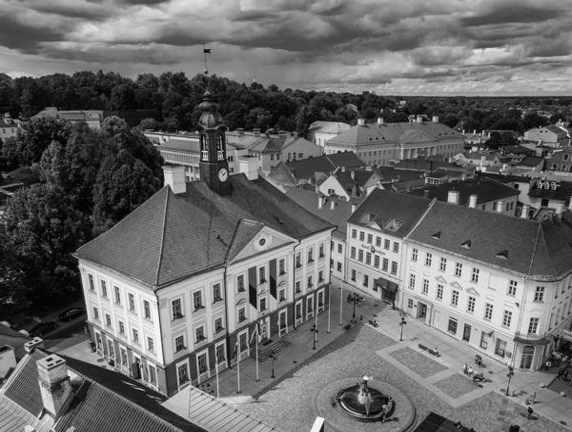

In [ ]:
test_X_resized = np.array(test_X_resized)
im = PIL.Image.fromarray(test_X_resized[0])
im

In [ ]:
test_X_normalized = test_X_resized / 255

In [ ]:
test_X_reshaped = test_X_normalized.reshape(-1, 432, 572, 1)
test_X_reshaped[0].shape

(432, 572, 1)

In [ ]:
preds = bigger_model.predict(test_X_reshaped)

3/3 [==============================] - 27s 8s/step


In [ ]:
preds[19][0]

0.3331359

In [ ]:
df.apply(lambda row: row[row == 'x'].index, axis=1)

In [ ]:
submission = pd.DataFrame(
    {'key': test.key, 'fare_amount': test_predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission_dt.csv', index = False)

-------------- old code --------------

Images that are in images folder, but not in csv files.

In [ ]:
notInCSV = [item for item in all_folder_names if item not in all_csv_names]
notInCSV

['img133.jpg',
 'img223.jpg',
 'img222.jpg',
 'img32.jpg',
 'img106.jpg',
 'img118.jpg',
 'img128.jpg']

Images that are in csv files, but not in images folder.

In [ ]:
notInImages = [item for item in all_csv_names if item not in all_folder_names]
notInImages

['img286.jpg',
 'img172.jpg',
 'img244.jpg',
 'img287.jpg',
 'img285.jpg',
 'img288.jpg']